<a href="https://colab.research.google.com/github/sid200016/VT_Hacks_111/blob/main/ML_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning model to classify invasive species**

This code is adopted from https://www.kaggle.com/code/vencerlanz09/wild-cats-classification-using-xception-100 in Kaggle. The model uses a pre-trained CNN called Xception and trains it on the top 5 invasive species found in virginia. To classify as non-invasive, a threshold value is used.

In [29]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

import os
import tensorflow_datasets as tfds


# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)

    # Seed value for NumPy
    np.random.seed(seed)

    # Seed value for Python's random library
    random.seed(seed)

    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [31]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-09-17 01:28:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-17 01:28:46 (115 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [32]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

Here, we upload data from our google drive.

In [33]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [34]:
# Walk through each directory
dataset = "/content/drive/MyDrive/invasive_data"
walk_through_dir(dataset)

There are 3 directories and 0 images in '/content/drive/MyDrive/invasive_data'.
There are 5 directories and 0 images in '/content/drive/MyDrive/invasive_data/test'.
There are 0 directories and 9 images in '/content/drive/MyDrive/invasive_data/test/chinese_mitten_crab'.
There are 0 directories and 10 images in '/content/drive/MyDrive/invasive_data/test/rusty_crayfish'.
There are 0 directories and 10 images in '/content/drive/MyDrive/invasive_data/test/sirex_wood_wasp'.
There are 0 directories and 10 images in '/content/drive/MyDrive/invasive_data/test/spotted_lanternfly'.
There are 0 directories and 10 images in '/content/drive/MyDrive/invasive_data/test/zebra_mussel'.
There are 5 directories and 0 images in '/content/drive/MyDrive/invasive_data/train'.
There are 0 directories and 172 images in '/content/drive/MyDrive/invasive_data/train/chinese_mitten_crab'.
There are 0 directories and 206 images in '/content/drive/MyDrive/invasive_data/train/rusty_crayfish'.
There are 0 directories an

In [35]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [36]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("/kaggle/input/grape-disease-dataset-original").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [37]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/invasive_data/test/chin...,chinese_mitten_crab
1,/content/drive/MyDrive/invasive_data/test/chin...,chinese_mitten_crab
2,/content/drive/MyDrive/invasive_data/test/chin...,chinese_mitten_crab
3,/content/drive/MyDrive/invasive_data/test/chin...,chinese_mitten_crab
4,/content/drive/MyDrive/invasive_data/test/chin...,chinese_mitten_crab
...,...,...
1109,/content/drive/MyDrive/invasive_data/validate/...,zebra_mussel
1110,/content/drive/MyDrive/invasive_data/validate/...,zebra_mussel
1111,/content/drive/MyDrive/invasive_data/validate/...,zebra_mussel
1112,/content/drive/MyDrive/invasive_data/validate/...,zebra_mussel


# Visualization


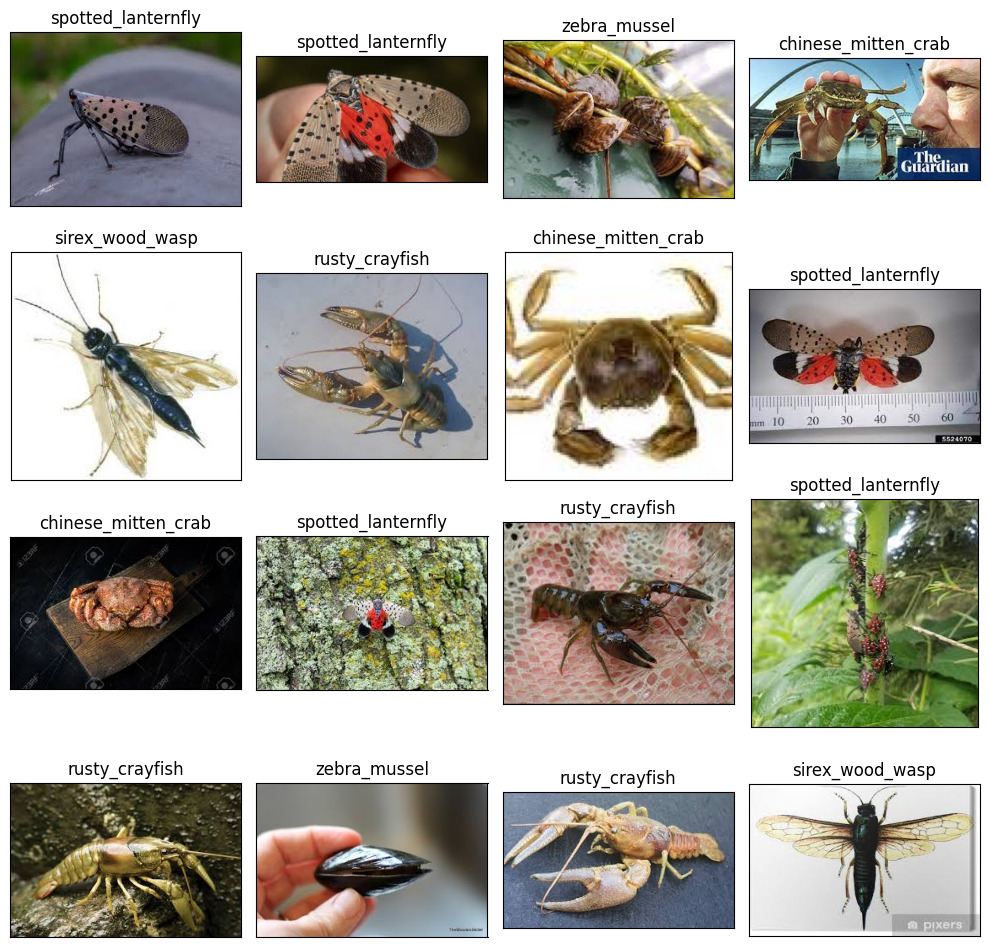

In [38]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [39]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

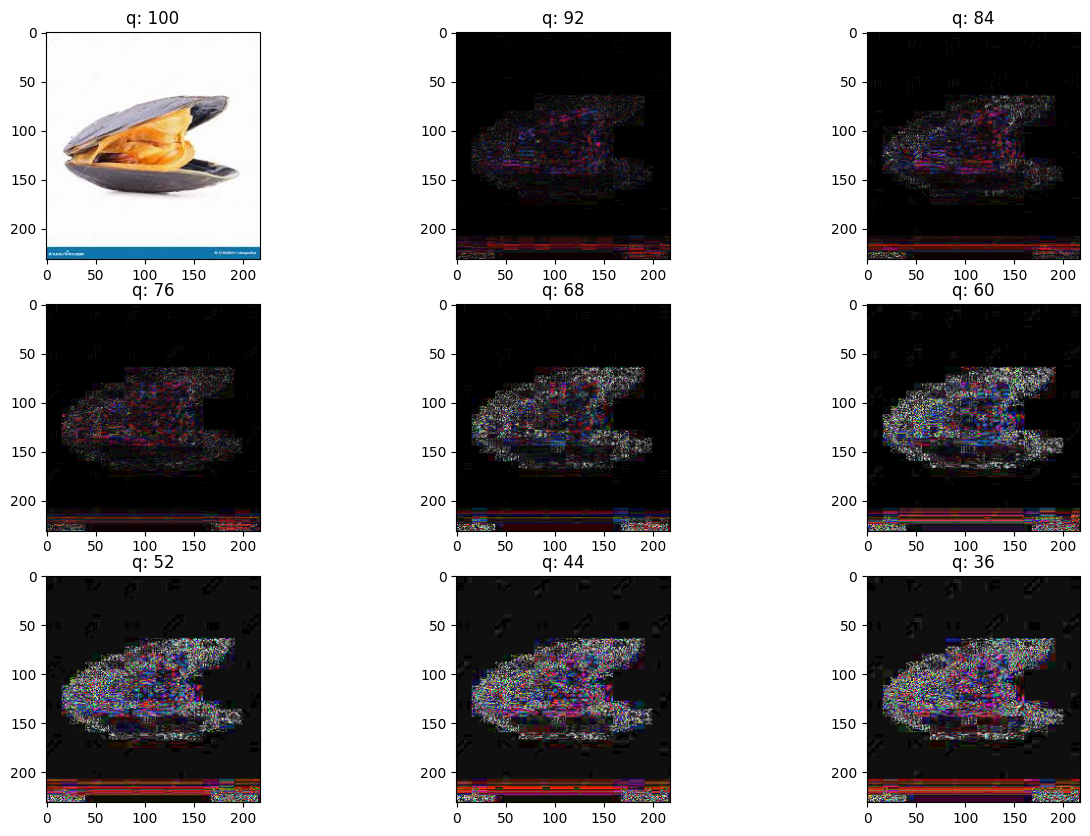

In [40]:
# View random sample from the dataset
p = random_sample('/content/drive/MyDrive/invasive_data/test/zebra_mussel')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

# Data Preprocessing

In [42]:
train_dataset = "/content/drive/MyDrive/invasive_data/train"
test_dataset = "/content/drive/MyDrive/invasive_data/test"
validation_dataset = "/content/drive/MyDrive/invasive_data/validate"

train_df = convert_path_to_df(train_dataset)
test_df = convert_path_to_df(test_dataset)
val_df = convert_path_to_df(validation_dataset)

In [43]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

In [44]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1015 validated image filenames belonging to 5 classes.
Found 50 validated image filenames belonging to 5 classes.
Found 49 validated image filenames belonging to 5 classes.


In [45]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

# Training the model


In [46]:
# Load the pretained model
pretrained_model = tf.keras.applications.xception.Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [50]:
# Create checkpoint callback
checkpoint_path = "invasive_speicies_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [51]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

Train Train Train

In [53]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "invasive_species_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/invasive_species_classification/20230917-013751
Epoch 1/100
23/32 [====================>.........] - ETA: 1:07 - loss: 2.6381 - accuracy: 0.2242

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


32/32 [==============================] - 252s 8s/step - loss: 2.5736 - accuracy: 0.2335 - val_loss: 1.6316 - val_accuracy: 0.2600
Epoch 2/100
32/32 [==============================] - 3s 97ms/step - loss: 2.3068 - accuracy: 0.2335 - val_loss: 1.4303 - val_accuracy: 0.4400
Epoch 3/100
32/32 [==============================] - 3s 97ms/step - loss: 2.0763 - accuracy: 0.2877 - val_loss: 1.3065 - val_accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 3s 100ms/step - loss: 1.8409 - accuracy: 0.3064 - val_loss: 1.2097 - val_accuracy: 0.6000
Epoch 5/100
32/32 [==============================] - 3s 98ms/step - loss: 1.7423 - accuracy: 0.3488 - val_loss: 1.1238 - val_accuracy: 0.6800
Epoch 6/100
32/32 [==============================] - 3s 95ms/step - loss: 1.6156 - accuracy: 0.3842 - val_loss: 1.0507 - val_accuracy: 0.7000
Epoch 7/100
32/32 [==============================] - 3s 84ms/step - loss: 1.5259 - accuracy: 0.4305 - val_loss: 0.9938 - val_accuracy: 0.7000
Epoch 8/100
32/32

# Model Evaluation

In [54]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.25507
Test Accuracy: 91.84%


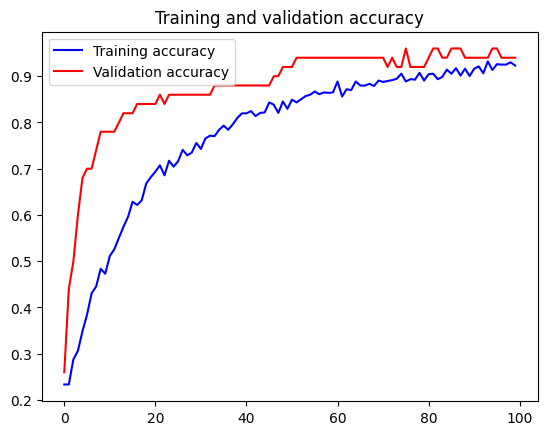

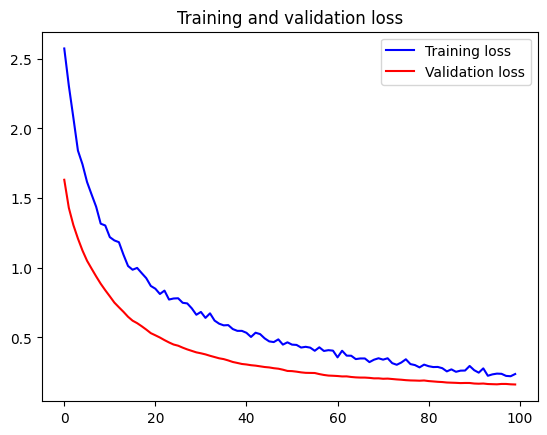

In [55]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# Testing

In [56]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

2/2 [==============================] - 1s 41ms/step
The first 5 predictions: ['chinese_mitten_crab', 'chinese_mitten_crab', 'chinese_mitten_crab', 'chinese_mitten_crab', 'chinese_mitten_crab']


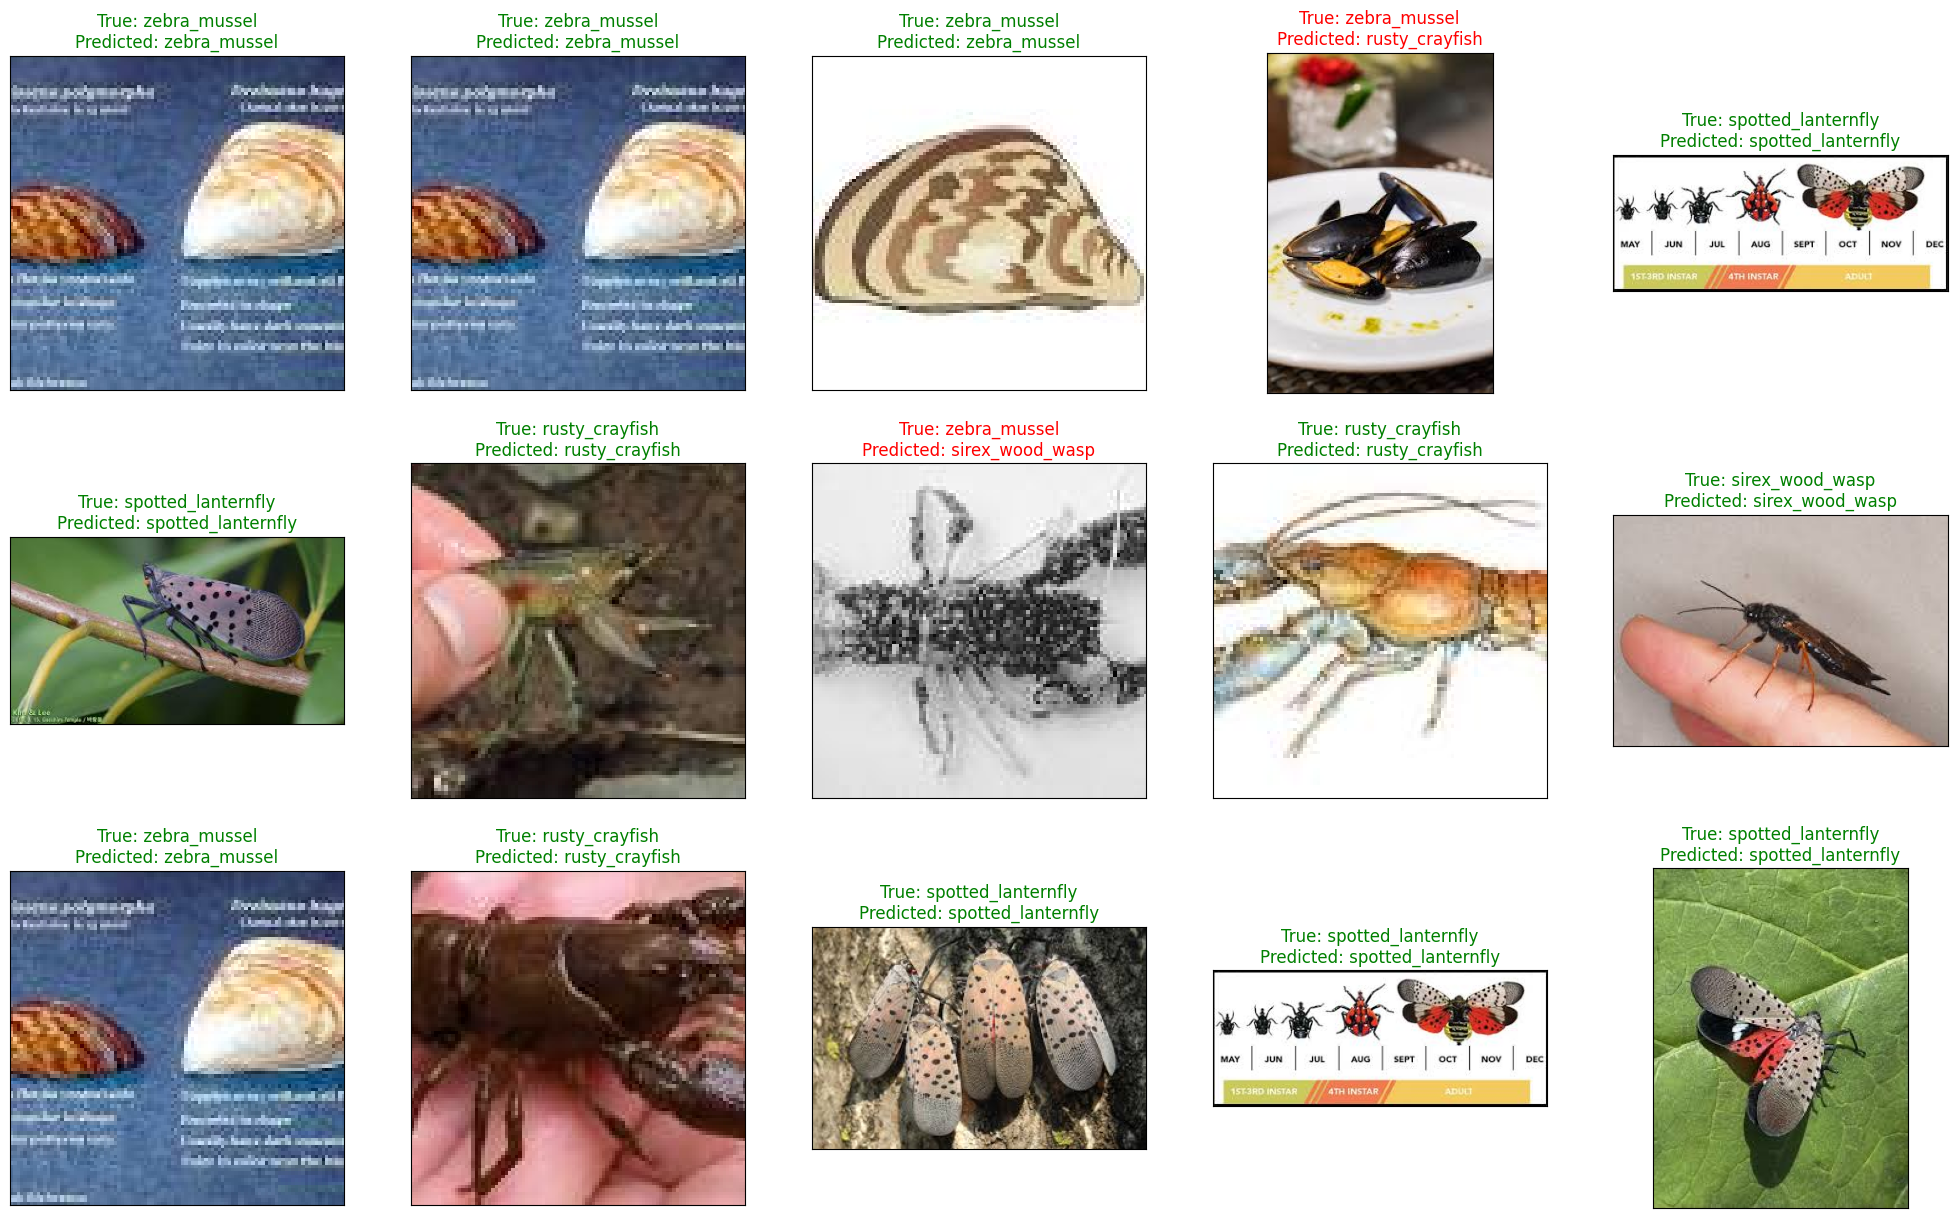

<Figure size 640x480 with 0 Axes>

In [57]:
 # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [58]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                     precision    recall  f1-score   support

chinese_mitten_crab       1.00      0.89      0.94         9
     rusty_crayfish       0.83      1.00      0.91        10
    sirex_wood_wasp       0.91      1.00      0.95        10
 spotted_lanternfly       0.91      1.00      0.95        10
       zebra_mussel       1.00      0.70      0.82        10

           accuracy                           0.92        49
          macro avg       0.93      0.92      0.92        49
       weighted avg       0.93      0.92      0.92        49



In [59]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
chinese_mitten_crab,1.000000,0.888889,0.941176,9.000000
rusty_crayfish,0.833333,1.000000,0.909091,10.000000
sirex_wood_wasp,0.909091,1.000000,0.952381,10.000000
spotted_lanternfly,0.909091,1.000000,0.952381,10.000000
zebra_mussel,1.000000,0.700000,0.823529,10.000000
accuracy,0.918367,0.918367,0.918367,0.918367
macro avg,0.930303,0.917778,0.915712,49.000000
weighted avg,0.928881,0.918367,0.915192,49.000000


This piece of code is used to check fucntionality of predicting non-invasive species. Rather than train the model with another class, we use a threshold value to state wether the model is non-invasive.

In [75]:
from google.colab import files
from PIL import Image
from io import BytesIO
from tensorflow.keras.applications.xception import preprocess_input

# Upload file
uploaded_image = files.upload()

# Pre process image uploaded
uploaded_image = list(uploaded.values())[0]
uploaded_image = Image.open(BytesIO(uploaded_image))
uploaded_image = uploaded_image.resize((224, 224))
uploaded_image = np.array(uploaded_image)
uploaded_image = preprocess_input(uploaded_image)
uploaded_image = np.expand_dims(uploaded_image, axis=0)


# Assuming you have obtained predictions from the model
predictions = model.predict(uploaded_image)

# Define the threshold value
threshold = 0.5  # Adjust this threshold as needed


if np.max(predictions) <= threshold:
        # Classify as "Non-Invasive" (last category)
        print("Non-Invasive")
else:
        # Classify based on the other categories
        category = predictions.argmax()
        if category == 0:
            print("Spotted Lanternfly")
        elif category == 1:
            print("Zebra Mussel")
        elif category == 2:
            print("Sirex Wood Wasp")
        elif category == 3:
            print("Rusty Crayfish")
        elif category == 4:
            print("Chinese Mitten Crab")

Saving WIN_20230916_22_45_49_Pro.jpg to WIN_20230916_22_45_49_Pro.jpg
1/1 [==============================] - 0s 24ms/step
Non-Invasive


Saving Our model to deploy

In [79]:
model.save(r'C:\Users\HP\VTHacks\VT_Hacks_111')